In [1]:
!pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 74.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=afc8860a7ededf223755382f668453687a66e7127beb87b61a82065dd8599003
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's depende

In [2]:
import pandas as pd
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score

import numpy as np
from statsmodels.stats.proportion import proportions_ztest

from google.colab import auth
from google.colab import drive
auth.authenticate_user()

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/My Drive/Colab Notebooks/prj3/'
# df = pd.read_csv(path + 'Bank Customer Churn Prediction.csv')
df = pd.read_csv(path + 'train.csv')
print(df.head(2))

   customer_id  credit_score  country  gender  age  tenure    balance  \
0     15706116           659  Germany  Female   30       8  154159.51   
1     15788224           669  Germany    Male   45       1  123949.75   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              0          40441.10      0  
1                1            0              0         110881.56      0  


In [4]:
df = df[df['country'] == 'Germany']
# df = df[df['products_number'] != 4]
# df.info()

In [5]:
# train_val, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['churn'])
# train, validation = train_test_split(train_val, test_size=0.25, random_state=42, stratify=train_val['churn'])

# # 분할된 데이터를 CSV 파일로 저장합니다.
# train.to_csv(path + 'train.csv', index=False)
# validation.to_csv(path + 'validation.csv', index=False)
# test.to_csv(path + 'test.csv', index=False)

#### churn = 1인 사용자에 대한 분석

In [6]:
# churned_df = df[df['churn'] != 0]
# churned_df.head()

In [7]:
# profile_c = ProfileReport(churned_df, title="Profiling Report :: Churned")
# profile_c

#### churne = 0인 사용자에 대한 분석

In [8]:
# notc_df = df[df['churn'] != 1]
# notc_df.head()

In [9]:
# profile_c = ProfileReport(notc_df, title="Profiling Report :: Churned")
# profile_c

(churn=0인 경우에 비해 churn=1인 경우가)
1. 두 데이터 모두 Credit Score의 median과 mean의 값이 비슷한 값을 가지고 있다, 또한 표준편차도 비슷
2. 나이가 많은 사람들(50>=)의 데이터수가 적고 그 이하에 집중적으로 분포되어 있음
3. Age의 median과 mean 값이 더 적음 (전체적으로 더 젊은 사람들로 구성), 또한 표준편차는 비슷
4. tenure의 차이는 크게 없음
5. Balnce의 median은 조금 더 크고, mean은 조금 더 작으며, CV는 꽤나 차이가 난다
6. estimated_salary의 경우 살짝 더 크며, CV는 비슷

In [10]:
profile1 = ProfileReport(df, title="Profiling Report :: ABC Bank Churn")
profile1

Output hidden; open in https://colab.research.google.com to view.

일반적으로 CV 값이 큰 변수를 포함시키는 것이 모델에 더 유용할 수 있습니다. 변수의 CV 값이 클수록 해당 변수의 값이 평균에서 큰 변동을 보이기 때문에, 해당 변수가 종속 변수에 미치는 영향을 더 잘 나타내거나 예측하는 데 더 중요할 수 있습니다. 따라서 CV 값이 큰 변수를 선택하여 모델에 포함시키는 것은 모델의 성능을 향상시킬 수 있습니다

#### CV 값 정리
1. tenure: 0.58588761
2. estimated_salary: 0.57602098
3. age: 0.26507954
4. balance: 0.2262335
5. credit_score: 0.15059559


#### outlier 제거 전 성능 확인

In [11]:
# 스케일링할 변수 선택
columns_to_scale = ['credit_score', 'age', 'balance', 'estimated_salary', 'tenure']

# StandardScaler 객체 생성
scaler = StandardScaler()

# 선택한 변수들에 대해 스케일링을 수행
df_scaled = df.copy()  # 데이터프레임 복사
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

In [12]:
# one-hot encoding할 변수 선택
columns_to_encode = ['gender', 'products_number']

# one-hot encoding 수행
df_encoded = pd.get_dummies(df_scaled, columns=columns_to_encode)
df_encoded.drop(columns = 'gender_Male', inplace = True)

# one-hot encoding 결과 확인
df_encoded


,customer_id,credit_score,country,age,tenure,balance,credit_card,active_member,estimated_salary,churn,gender_Female,products_number_1,products_number_2,products_number_3
0,15706116,0.067179,Germany,-0.928880,1.030434,1.278669,1,0,-1.024242,0,1,1,0,0
1,15788224,0.170738,Germany,0.519419,-1.387969,0.175041,0,0,0.180073,0,0,1,0,0
2,15588622,-0.554181,Germany,-1.411646,0.684948,-0.393729,1,1,-0.364902,0,0,1,0,0
3,15761775,-0.564537,Germany,-1.894412,1.030434,2.233413,1,1,-1.210400,0,0,0,1,0
4,15654456,-1.465508,Germany,0.809079,0.339462,1.116706,0,0,-0.205868,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,15785705,0.543554,Germany,0.422866,1.721406,-0.453975,1,0,0.633796,1,1,1,0,0
1487,15783097,1.662001,Germany,-1.218540,0.339462,-0.285322,1,0,-0.921979,0,0,1,0,0
1488,15706810,-0.481689,Germany,-0.735773,-1.387969,-0.469674,0,1,-0.705895,0,1,0,1,0
1489,15694859,1.019930,Germany,-1.121986,1.721406,0.503188,1,1,-0.918423,0,1,0,1,0


In [13]:
# features와 target 분리
feature_cols = ['credit_score', 'age', 'balance', 'credit_card', 'active_member',
                'estimated_salary', 'gender_Female', 'tenure', 'products_number_1', 'products_number_2', 'products_number_3']
X = df_encoded[feature_cols]
y = df_encoded['churn']  # churn을 target으로 사용

# train-test split (테스트 데이터는 계층적 샘플링을 사용하지 않습니다)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train-validation split (검증용 데이터는 계층적 샘플링을 사용합니다)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2

# 각 데이터셋의 크기 확인
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Train set size: (894, 11)
Validation set size: (298, 11)
Test set size: (299, 11)


In [14]:
# 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, recall_score, f1_score

# 검증용 데이터로 예측 및 성능 평가
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("\n-----------------------------------------------\n")
# 테스트용 데이터로 예측 및 성능 평가
test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

Validation Accuracy: 0.7651006711409396
Validation Recall: 0.5102040816326531
Validation F1 Score: 0.588235294117647

-----------------------------------------------

Test Accuracy: 0.7525083612040134
Test Recall: 0.4939759036144578
Test F1 Score: 0.5256410256410257


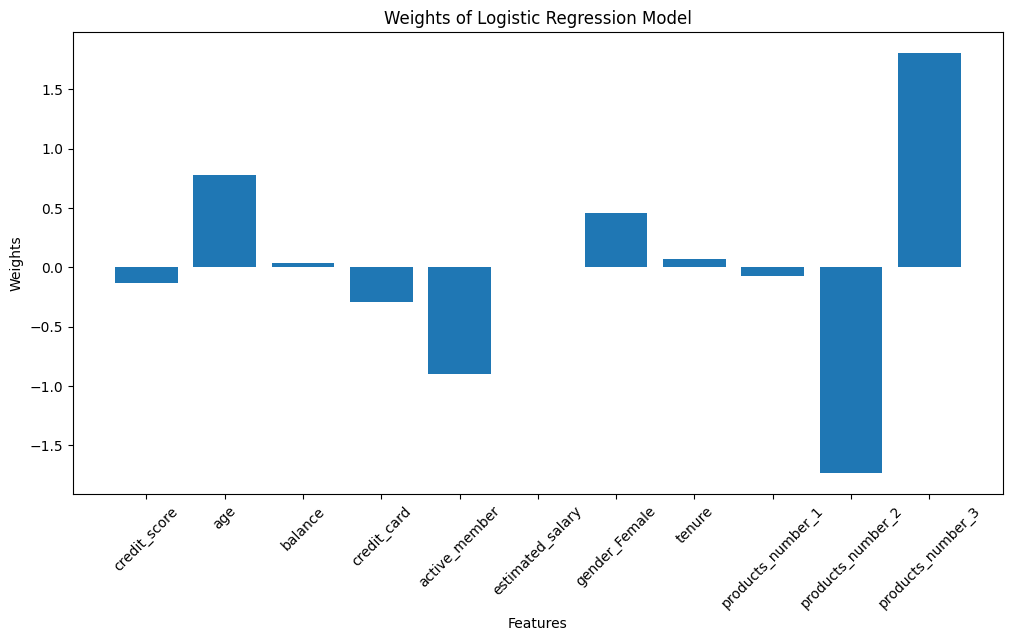

In [15]:
weights = dict(zip(feature_cols, model.coef_[0]))

# 가중치 시각화
plt.figure(figsize=(12, 6))
plt.bar(weights.keys(), weights.values())
plt.title('Weights of Logistic Regression Model')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.xticks(rotation=45)
plt.show()

#### One-Class SVM을 통한 outlier 제거
One-Class SVM은 데이터의 대다수가 정상 클래스에 속하는 경우에만 효과적으로 작동하는 지도 학습 알고리즘입니다. 이 알고리즘은 데이터의 분포를 학습하고, 이상치로부터 멀리 떨어진 영역을 식별하여 정상 데이터를 분리합니다. 이상치는 이 경계 영역에 속하는 데이터 포인트로 간주됩니다.

In [16]:
from sklearn.svm import OneClassSVM

cols_to_drop = ['customer_id', 'country']

df_processed = df_encoded.drop(columns=cols_to_drop, axis=1)
# One-Class SVM 모델 초기화
model = OneClassSVM(nu=0.01)  # nu는 이상치 비율을 나타내는 매개변수입니다. 일반적으로 작은 값으로 설정됩니다.

# 모델 학습
model.fit(df_processed)

# 이상치 예측
outliers = model.predict(df_processed)

In [17]:
# 이상치 예측 결과를 DataFrame에 추가
df_processed['outlier'] = outliers

# 이상치로 분류된 데이터만 선택
OCS_data = df_processed[df_processed['outlier'] != -1]

# 결과 출력
OCS_data

,credit_score,age,tenure,balance,credit_card,active_member,estimated_salary,churn,gender_Female,products_number_1,products_number_2,products_number_3,outlier
0,0.067179,-0.928880,1.030434,1.278669,1,0,-1.024242,0,1,1,0,0,1
1,0.170738,0.519419,-1.387969,0.175041,0,0,0.180073,0,0,1,0,0,1
2,-0.554181,-1.411646,0.684948,-0.393729,1,1,-0.364902,0,0,1,0,0,1
4,-1.465508,0.809079,0.339462,1.116706,0,0,-0.205868,1,0,1,0,0,1
5,-0.895929,0.036653,-1.042483,-0.809441,1,0,0.925575,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,0.543554,0.422866,1.721406,-0.453975,1,0,0.633796,1,1,1,0,0,1
1487,1.662001,-1.218540,0.339462,-0.285322,1,0,-0.921979,0,0,1,0,0,1
1488,-0.481689,-0.735773,-1.387969,-0.469674,0,1,-0.705895,0,1,0,1,0,1
1489,1.019930,-1.121986,1.721406,0.503188,1,1,-0.918423,0,1,0,1,0,1


In [18]:
print("total number of outliers detected using OneClassSVM is : " + str(df.shape[0] - OCS_data.shape[0]))

total number of outliers detected using OneClassSVM is : 37


#### outlier 제거
모델의 안정성 향상: 이상치는 모델의 예측을 왜곡시킬 수 있습니다. 예를 들어, 회귀 분석에서 이상치가 있는 경우 모델이 이상치에 과도하게 적응하여 전체 데이터의 패턴을 잘 파악하지 못할 수 있습니다. 이상치를 제거하면 모델이 보다 일반적인 패턴을 학습하도록 도울 수 있습니다.

모델의 정확도 향상: 이상치는 모델의 정확도를 저하시킬 수 있습니다. 모델이 이상치에 민감하게 반응하면 일반적인 경우보다 더 큰 오류를 만들어낼 수 있습니다. 이를 방지하기 위해 이상치를 제거하면 모델의 예측 정확도가 향상될 수 있습니다.

데이터의 일관성 유지: 이상치가 있는 데이터는 데이터의 일관성을 해칠 수 있습니다. 이상치가 있는 데이터를 포함하여 모델을 훈련시키면 모델이 실제 데이터에서 예상하는 것보다 더 나쁜 성능을 낼 수 있습니다. 이상치를 제거하면 데이터의 일관성을 높일 수 있습니다.

이상치를 제거할 때는 조심해야 합니다. 데이터의 중요한 정보가 이상치에 담겨 있을 수도 있기 때문입니다. 따라서 이상치를 제거하기 전에 데이터를 충분히 탐색하고 해당 이상치가 실제로 오류인지 또는 유효한 데이터 포인트인지 확인해야 합니다.

In [19]:
# features와 target 분리
X = OCS_data.drop(columns=['churn'])
y = OCS_data['churn']  # churn을 target으로 사용

# train-test split (테스트 데이터는 계층적 샘플링을 사용하지 않습니다)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train-validation split (검증용 데이터는 계층적 샘플링을 사용합니다)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2

# 각 데이터셋의 크기 확인
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Train set size: (872, 12)
Validation set size: (291, 12)
Test set size: (291, 12)


In [20]:
# 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 검증용 데이터로 예측 및 성능 평가
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("\n-----------------------------------------------\n")
# 테스트용 데이터로 예측 및 성능 평가
test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

Validation Accuracy: 0.7319587628865979
Validation Recall: 0.5555555555555556
Validation F1 Score: 0.5617977528089888

-----------------------------------------------

Test Accuracy: 0.7903780068728522
Test Recall: 0.5588235294117647
Test F1 Score: 0.6514285714285715


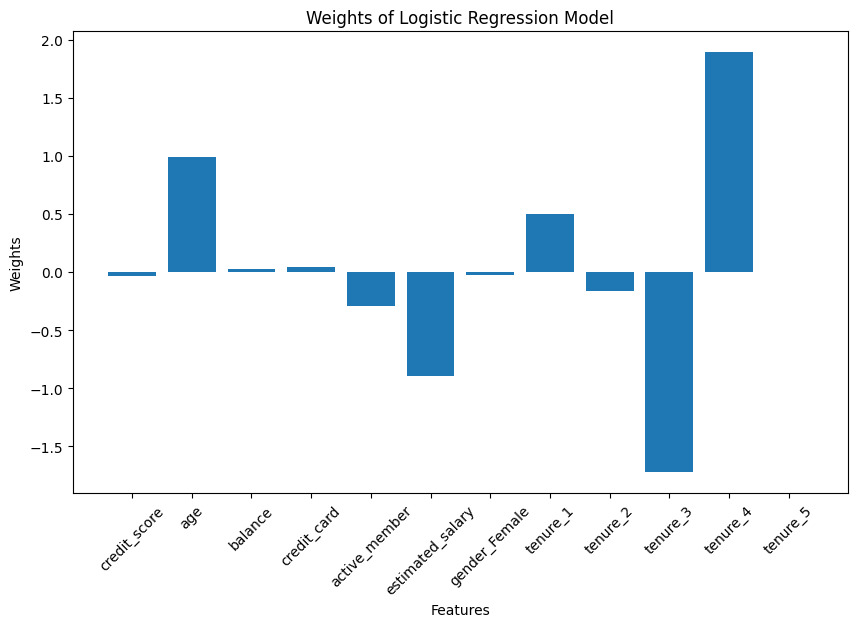

In [21]:
# 모델 객체가 있다고 가정하고 가중치 추출
feature_cols = ['credit_score', 'age', 'balance', 'credit_card', 'active_member',
                'estimated_salary', 'gender_Female', 'tenure_1', 'tenure_2',
                'tenure_3', 'tenure_4', 'tenure_5', 'tenure_6', 'tenure_7', 'tenure_8', 'tenure_9',
                'tenure_10', 'products_number_1', 'products_number_2', 'products_number_3']

weights = dict(zip(feature_cols, model.coef_[0]))


# 가중치 시각화
plt.figure(figsize=(10, 6))
plt.bar(weights.keys(), weights.values())
plt.title('Weights of Logistic Regression Model')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.xticks(rotation=45)
plt.show()

#### isolation forest를 활용한 outlier 제거
Isolation Forest는 이상치를 찾는 데 사용되는 비지도 학습 알고리즘 중 하나입니다. 이 알고리즘은 데이터 포인트를 완전히 랜덤하게 선택하여 이상치를 찾아냅니다. 일반적인 데이터 포인트보다 이상치가 더 빨리 "분리"될 것으로 예상되기 때문에, 이상치를 빠르게 탐지할 수 있습니다. 이러한 특성 때문에 Isolation Forest는 매우 큰 데이터셋에서도 효율적으로 작동할 수 있습니다.

In [22]:
from sklearn.ensemble import IsolationForest

# Isolation Forest 모델 초기화
model = IsolationForest(contamination=0.02)  # contamination은 이상치 비율을 나타내는 매개변수입니다.

# 모델 학습
model.fit(df_processed)

# 이상치 예측
outliers = model.predict(df_processed)

# 이상치 예측 결과를 DataFrame에 추가
df_processed['outlier'] = outliers

# 이상치로 분류된 데이터만 선택
ISF_data = df_processed[df_processed['outlier'] != -1]

# 결과 출력
ISF_data

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,credit_score,age,tenure,balance,credit_card,active_member,estimated_salary,churn,gender_Female,products_number_1,products_number_2,products_number_3,outlier
0,0.067179,-0.928880,1.030434,1.278669,1,0,-1.024242,0,1,1,0,0,1
1,0.170738,0.519419,-1.387969,0.175041,0,0,0.180073,0,0,1,0,0,1
2,-0.554181,-1.411646,0.684948,-0.393729,1,1,-0.364902,0,0,1,0,0,1
3,-0.564537,-1.894412,1.030434,2.233413,1,1,-1.210400,0,0,0,1,0,1
4,-1.465508,0.809079,0.339462,1.116706,0,0,-0.205868,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,0.543554,0.422866,1.721406,-0.453975,1,0,0.633796,1,1,1,0,0,1
1487,1.662001,-1.218540,0.339462,-0.285322,1,0,-0.921979,0,0,1,0,0,1
1488,-0.481689,-0.735773,-1.387969,-0.469674,0,1,-0.705895,0,1,0,1,0,1
1489,1.019930,-1.121986,1.721406,0.503188,1,1,-0.918423,0,1,0,1,0,1


In [23]:
print("total number of outliers detected using isolation forest is : " + str(df.shape[0] - ISF_data.shape[0]))

total number of outliers detected using isolation forest is : 30


In [24]:
# features와 target 분리
X = ISF_data.drop(columns=['churn'])
y = ISF_data['churn']  # churn을 target으로 사용

# train-test split (테스트 데이터는 계층적 샘플링을 사용하지 않습니다)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train-validation split (검증용 데이터는 계층적 샘플링을 사용합니다)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2

# 각 데이터셋의 크기 확인
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Train set size: (876, 12)
Validation set size: (292, 12)
Test set size: (293, 12)


In [25]:
# 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 검증용 데이터로 예측 및 성능 평가
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("\n-----------------------------------------------\n")
# 테스트용 데이터로 예측 및 성능 평가
test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

Validation Accuracy: 0.821917808219178
Validation Recall: 0.5730337078651685
Validation F1 Score: 0.6623376623376623

-----------------------------------------------

Test Accuracy: 0.7610921501706485
Test Recall: 0.5051546391752577
Test F1 Score: 0.5833333333333333


#### 마지막으로 Local Outlier Factor (LOF) 방식으로 진행
LOF는 이상치를 찾는 데 사용되는 비지도 학습 알고리즘으로, 주변 이웃과의 거리를 기반으로 각 데이터 포인트의 이상치 점수를 계산합니다. 이상치는 주변 이웃보다 더 드물게 나타나는 데이터 포인트로 정의됩니다. 따라서 LOF는 주변 이웃의 밀도를 고려하여 이상치를 탐지합니다.

In [26]:
from sklearn.neighbors import LocalOutlierFactor

# Local Outlier Factor 모델 초기화
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# 모델 학습 및 이상치 예측
outliers = lof_model.fit_predict(df_processed)

# 이상치 예측 결과를 DataFrame에 추가
df_processed['outlier'] = outliers

# 이상치로 분류된 데이터만 선택
LOF_data = df_processed[df_processed['outlier'] != -1]

# 결과 출력
LOF_data


,credit_score,age,tenure,balance,credit_card,active_member,estimated_salary,churn,gender_Female,products_number_1,products_number_2,products_number_3,outlier
0,0.067179,-0.928880,1.030434,1.278669,1,0,-1.024242,0,1,1,0,0,1
1,0.170738,0.519419,-1.387969,0.175041,0,0,0.180073,0,0,1,0,0,1
2,-0.554181,-1.411646,0.684948,-0.393729,1,1,-0.364902,0,0,1,0,0,1
3,-0.564537,-1.894412,1.030434,2.233413,1,1,-1.210400,0,0,0,1,0,1
4,-1.465508,0.809079,0.339462,1.116706,0,0,-0.205868,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,0.543554,0.422866,1.721406,-0.453975,1,0,0.633796,1,1,1,0,0,1
1487,1.662001,-1.218540,0.339462,-0.285322,1,0,-0.921979,0,0,1,0,0,1
1488,-0.481689,-0.735773,-1.387969,-0.469674,0,1,-0.705895,0,1,0,1,0,1
1489,1.019930,-1.121986,1.721406,0.503188,1,1,-0.918423,0,1,0,1,0,1


#### 시각화?

In [27]:
print("total number of outliers detected using LOF is : " + str(df.shape[0] - ISF_data.shape[0]))

total number of outliers detected using LOF is : 30


In [28]:
# features와 target 분리
X = LOF_data.drop(columns=['churn'])
y = LOF_data['churn']  # churn을 target으로 사용

# train-test split (테스트 데이터는 계층적 샘플링을 사용하지 않습니다)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train-validation split (검증용 데이터는 계층적 샘플링을 사용합니다)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.25 x 0.8 = 0.2

# 각 데이터셋의 크기 확인
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Train set size: (885, 12)
Validation set size: (295, 12)
Test set size: (296, 12)


In [29]:
# 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 검증용 데이터로 예측 및 성능 평가
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("\n-----------------------------------------------\n")
# 테스트용 데이터로 예측 및 성능 평가
test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

Validation Accuracy: 0.7220338983050848
Validation Recall: 0.5376344086021505
Validation F1 Score: 0.5494505494505495

-----------------------------------------------

Test Accuracy: 0.7702702702702703
Test Recall: 0.5154639175257731
Test F1 Score: 0.5952380952380952


# !!!!!!!!!!!!성능 비교는 Key Metric 설정하고 비교

#### 결합을 고려해봐야 하는 변수들 (중요도 높은 순서)

-> 뚜렷한 차이 없고 분포 비율 엉망

credit_card

products_number

tenure

credit_score

balance

estimated_salary

age
-> 뚜렷한 차이 있고 분포 비율 맞음

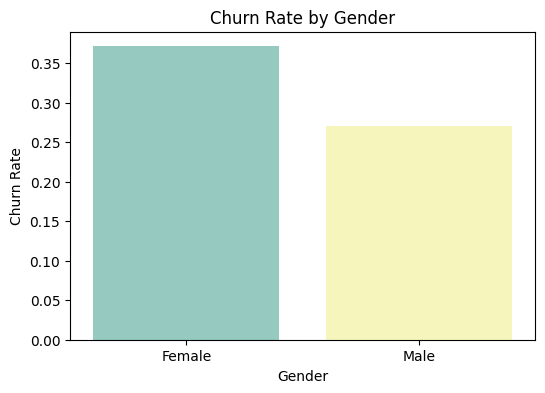

In [30]:
churn_rate_by_gender = df.groupby('gender')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x='gender', y='churn', data=churn_rate_by_gender, palette='Set3')
plt.title('Churn Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')
plt.show()

#### 성별에 따른 차이가 유의미하며, 두 클래스의 균형이 어느정도 잡혀있다 (Male 53%, female 47%) -> CIA에서 2016년 추산한 독일의 성비는 1.06, 즉 남성이 51% 이므로 인류통계학적으로 문제 없다고 판단

-> 그대로 사용 가능

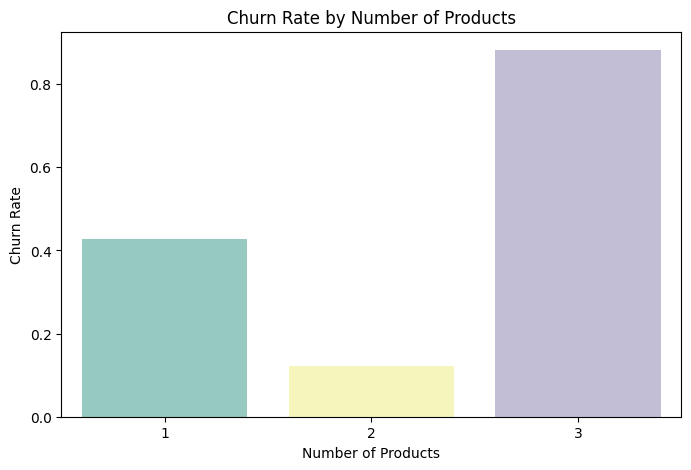

In [31]:
# products_number를 기준으로 그룹화하여 churn rate 계산
churn_rate_by_products_number = df.groupby('products_number')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x='products_number', y='churn', data=churn_rate_by_products_number, palette='Set3')
plt.title('Churn Rate by Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Churn Rate')
plt.show()

In [32]:
# products_number별 churn rate와 데이터 개수 구하기
products_number_groups = df.groupby('products_number')['churn']

# 각 그룹의 데이터 개수 구하기
group_counts = products_number_groups.count()

# 각 그룹의 churn rate 구하기
group_churn_rate = products_number_groups.mean()

# 결과 출력
print("Products_number\tData Count\tChurn Rate")
for products_number, count, churn_rate in zip(group_counts.index, group_counts, group_churn_rate):
    print(f"{products_number}\t\t{count}\t\t{churn_rate:.2f}")

Products_number	Data Count	Churn Rate
1		831		0.43
2		609		0.12
3		51		0.88


#### 데이터의 치우침이 굉장히 큰편이다. overfitting 문제가 크게 발생할 것 같음

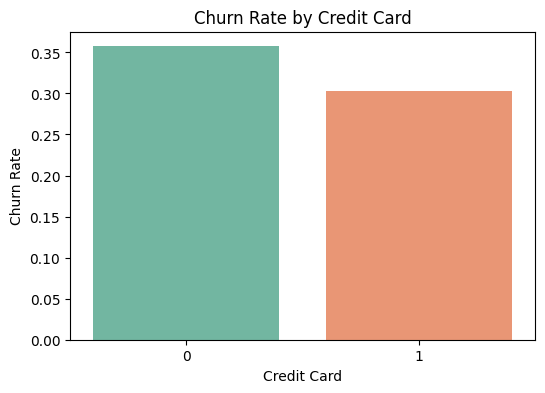

In [33]:
# credit_card를 기준으로 그룹화하여 churn rate 계산
churn_rate_by_credit_card = df.groupby('credit_card')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x='credit_card', y='churn', data=churn_rate_by_credit_card, palette='Set2')
plt.title('Churn Rate by Credit Card')
plt.xlabel('Credit Card')
plt.ylabel('Churn Rate')
plt.show()

#### credit card의 유무는 큰 차이가 없음. 그런데 데이터의 치우침이 큰편임 1	(71.6%), 0	(28.4%)


#### 가설 : 신용카드가 있는 사용자의 경우 연회비를 내는 사용자이기 때문에 active 상태일 확률이 높다.

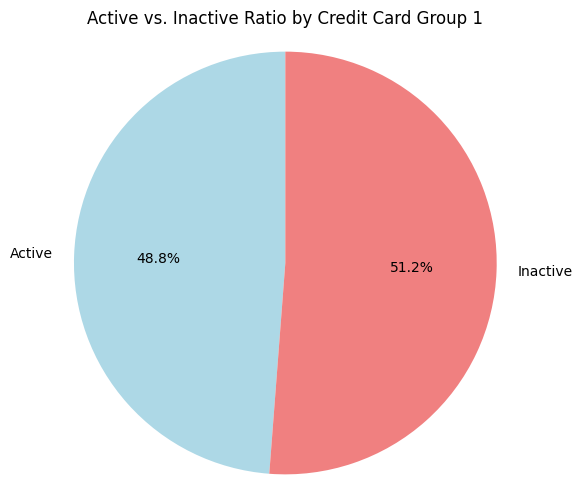

In [34]:
# credit_card가 1인 그룹에서 active한 사용자와 inactive한 사용자의 비율 계산
credit_card_group = df[df['credit_card'] == 1]
active_ratio_by_credit_card = credit_card_group['active_member'].mean()
inactive_ratio_by_credit_card = 1 - active_ratio_by_credit_card

# 시각화
labels = ['Active', 'Inactive']
sizes = [active_ratio_by_credit_card, inactive_ratio_by_credit_card]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Active vs. Inactive Ratio by Credit Card Group 1')
plt.axis('equal')
plt.show()

#### 비율에는 차이가 거의 없음!(가설은 기각) 두 변수를 묶어 churn rate에 대한 분석 진행

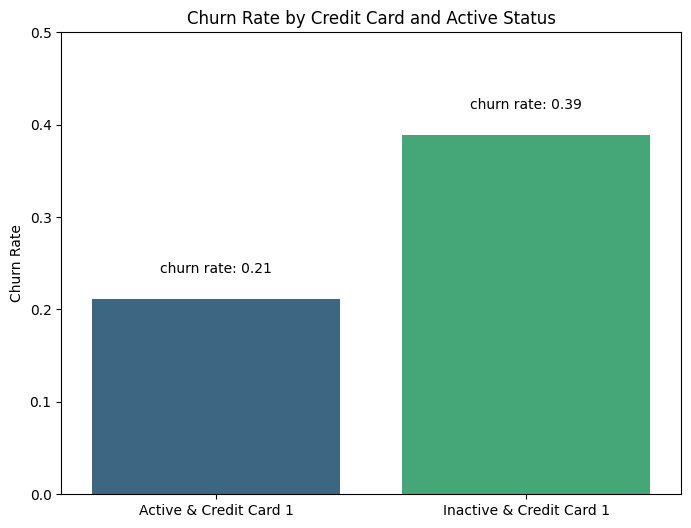

In [35]:
# credit_card가 1이고 active인 그룹의 churn rate 계산
active_churn_rate = df[(df['credit_card'] == 1) & (df['active_member'] == 1)]['churn'].mean()

# credit_card가 1이고 inactive인 그룹의 churn rate 계산
inactive_churn_rate = df[(df['credit_card'] == 1) & (df['active_member'] == 0)]['churn'].mean()

# 시각화
group_names = ['Active & Credit Card 1', 'Inactive & Credit Card 1']
churn_rates = [active_churn_rate, inactive_churn_rate]

plt.figure(figsize=(8, 6))
sns.barplot(x=group_names, y=churn_rates, palette="viridis")
plt.title('Churn Rate by Credit Card and Active Status')
plt.ylabel('Churn Rate')
plt.ylim(0, 0.5)

for i in range(len(group_names)):
    plt.text(i, churn_rates[i] + 0.01, f"churn rate: {churn_rates[i]:.2f}\n", ha='center')
plt.show()

#### 그렇다면, credit card를 가지지 않은 사용자에 대해서도 동일하게 분석 해보자

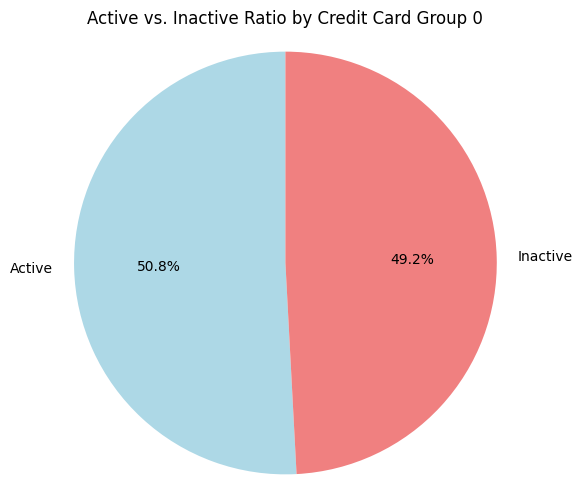

In [36]:
credit_card_group = df[df['credit_card'] == 0]
active_ratio_by_credit_card = credit_card_group['active_member'].mean()
inactive_ratio_by_credit_card = 1 - active_ratio_by_credit_card

# 시각화
labels = ['Active', 'Inactive']
sizes = [active_ratio_by_credit_card, inactive_ratio_by_credit_card]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Active vs. Inactive Ratio by Credit Card Group 0')
plt.axis('equal')
plt.show()

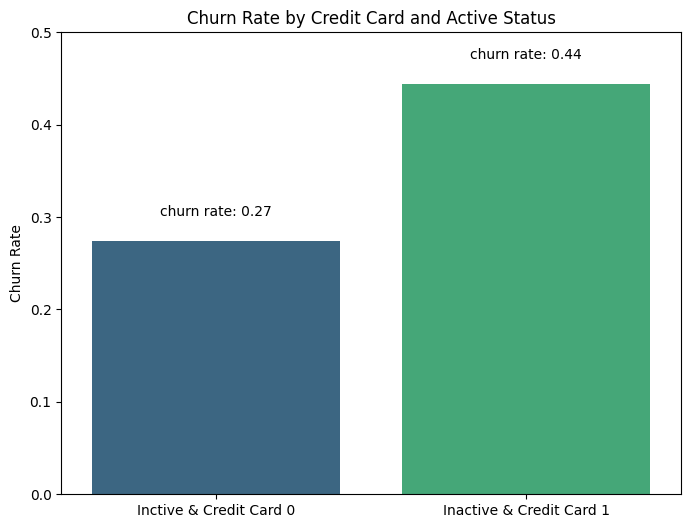

In [37]:
# credit_card가 1이고 active인 그룹의 churn rate 계산
active_churn_rate = df[(df['credit_card'] == 0) & (df['active_member'] == 1)]['churn'].mean()

# credit_card가 1이고 inactive인 그룹의 churn rate 계산
inactive_churn_rate = df[(df['credit_card'] == 0) & (df['active_member'] == 0)]['churn'].mean()



# 시각화
group_names = ['Inctive & Credit Card 0', 'Inactive & Credit Card 1']
churn_rates = [active_churn_rate, inactive_churn_rate]

plt.figure(figsize=(8, 6))
sns.barplot(x=group_names, y=churn_rates, palette="viridis")
plt.title('Churn Rate by Credit Card and Active Status')
plt.ylabel('Churn Rate')
plt.ylim(0, 0.5)

for i in range(len(group_names)):
    plt.text(i, churn_rates[i] + 0.01, f"churn rate: {churn_rates[i]:.2f}\n", ha='center')
plt.show()

#### credit card와 active를 묶으니 차이가 크게 보이기는 하는데 솔직히 active_members를 기준으로 묶은 경우와 큰 차이를 보이지는 않는다 -> 그렇다면 두 변수를 합쳐서 그룹으로 만들 필요가 없다

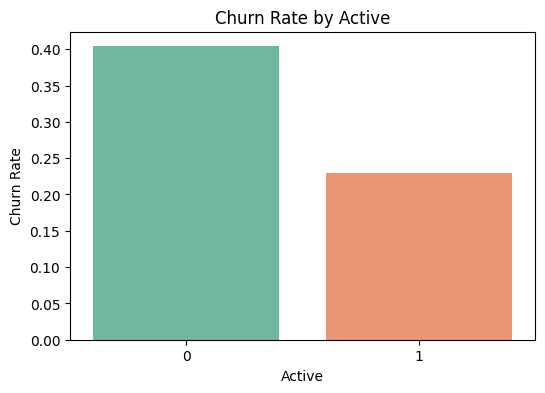

In [38]:
# active_user를 기준으로 그룹화하여 churn rate 계산
churn_rate_by_active = df.groupby('active_member')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x='active_member', y='churn', data=churn_rate_by_active, palette='Set2')
plt.title('Churn Rate by Active')
plt.xlabel('Active')
plt.ylabel('Churn Rate')
plt.show()

#### inactive(0)한 사용자의 churn rate가 유의미하게 높음

#### 또한, 데이터가 매우 균형잡혀 있음. 0	(50.2%),1	(49.8%) -> 그대로 사용 가능

# 데이터를 그룹화 할 때 중요한 것

### 1. 그룹간의 차이가 잘 보이는가? (= 모델의 성능)

### 2. 도메인 지식 (= 모델의 해석력)

### 3. 모델의 일반화 성능에 미치는 영향

### 4. 클래스의 데이터 비율

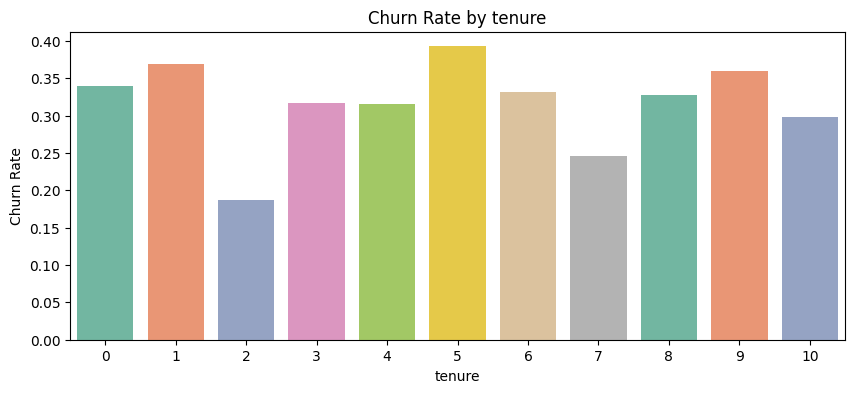

In [39]:
# tenure를 기준으로 그룹화하여 churn rate 계산
churn_rate_by_tenure = df.groupby('tenure')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 4))
sns.barplot(x='tenure', y='churn', data=churn_rate_by_tenure, palette='Set2')
plt.title('Churn Rate by tenure')
plt.xlabel('tenure')
plt.ylabel('Churn Rate')
plt.show()

#### 아직 애매하다. 그룹을 나눠서 확인해보자

In [40]:
# tenure 열을 기준으로 세 그룹을 만듭니다
def create_tenure_groups(tenure):
    if tenure <= 3:
        return '0~3'
    elif 4 <= tenure <= 6:
        return '4~6'
    else:
        return '7~10'

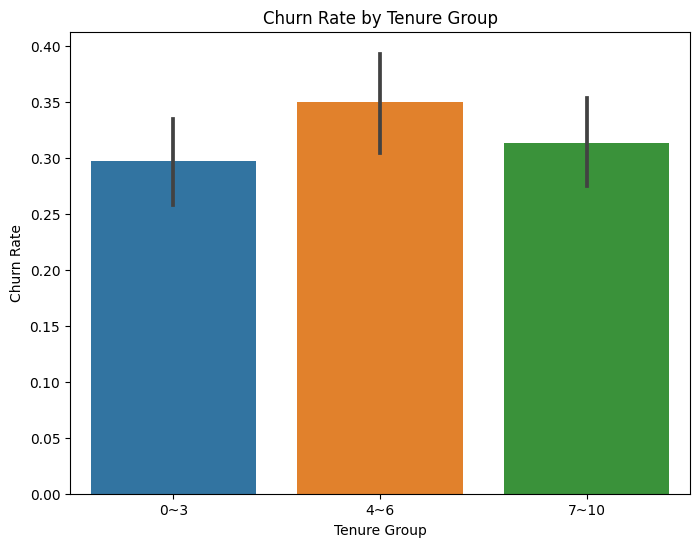

In [41]:
# 새로운 그룹 열을 생성합니다
df['tenure_group'] = df['tenure'].apply(create_tenure_groups)

# 각 그룹별 churn rate를 계산합니다
churn_rate_by_tenure_group = df.groupby('tenure_group')['churn'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x='tenure_group', y='churn', data=df, order=['0~3', '4~6', '7~10'])
plt.title('Churn Rate by Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate')
plt.show()

In [42]:
# 그룹화된 데이터프레임 생성
grouped_df = df.groupby('tenure_group')['churn']

# 각 그룹의 총 데이터 개수와 churn rate 출력
for group_name, group_data in grouped_df:
    total_count = len(group_data)
    churn_rate = group_data.mean()
    print(f"Group: {group_name}, Total Count: {total_count}, Churn Rate: {churn_rate}")


Group: 0~3, Total Count: 532, Churn Rate: 0.29699248120300753
Group: 4~6, Total Count: 438, Churn Rate: 0.3493150684931507
Group: 7~10, Total Count: 521, Churn Rate: 0.31285988483685223


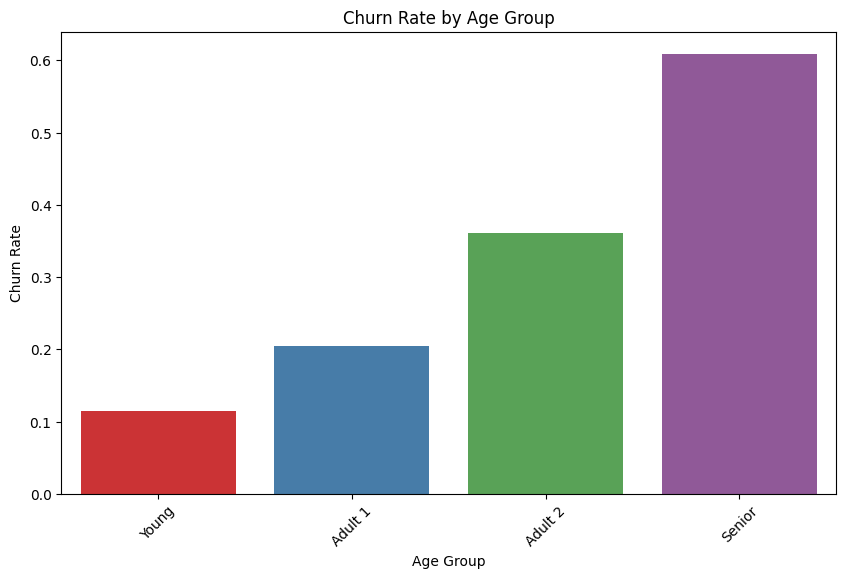

In [43]:
# Quantile statistics
# Minimum	18
# 5-th percentile	25
# Q1	32
# median	38
# Q3	45
# 95-th percentile	59
# Maximum	84
# Range	66
# Interquartile range (IQR)	13

age_bins = [18, 32, 38, 45, 84]
labels = ['Young', 'Adult 1', 'Adult 2', 'Senior']

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=labels)
churn_rate_by_age = df.groupby('age_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='churn', data=churn_rate_by_age, palette='Set1')
plt.title('Churn Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

In [44]:
# 각 구간별 데이터 개수와 churn rate 확인
for i in range(len(age_bins)-1):
    lower_bound = age_bins[i]
    upper_bound = age_bins[i+1]
    group_df = df[(df['age'] >= lower_bound) & (df['age'] < upper_bound)]
    churn_rate = group_df['churn'].mean()
    print(f"Age Group {i+1} (range {lower_bound} to {upper_bound}): {group_df.shape[0]} rows, Churn Rate: {churn_rate:.2f}")


Age Group 1 (range 18 to 32): 317 rows, Churn Rate: 0.12
Age Group 2 (range 32 to 38): 382 rows, Churn Rate: 0.18
Age Group 3 (range 38 to 45): 391 rows, Churn Rate: 0.32
Age Group 4 (range 45 to 84): 401 rows, Churn Rate: 0.60


#### 통계량으로 구간을 나누면 참 이쁘게 결과가 나오긴 하는데, 해석력이 떨어지고 일반화 성능이 떨어질 가능성이 있음

#### 인구 통계학적으로 새로운 approach를 적용해봤음


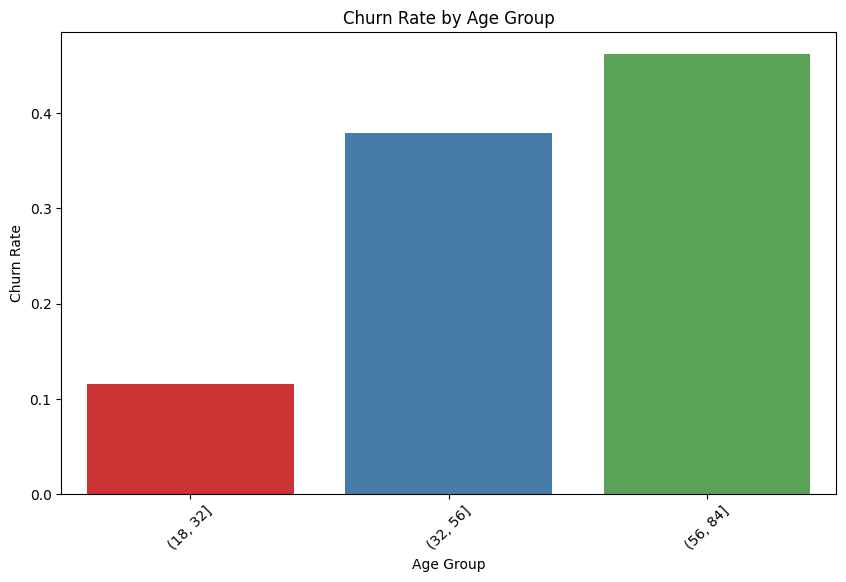

In [45]:
## 18~32 : 독일의 평균 결혼 나이인 32세를 기준 (결혼 전), 주로 모바일 뱅킹 앱을 통해 은행 서비스를 이용. 일반적으로 신용카드 및 대출에 관심이 높고 저축보다는 투자/적금에 관심이 높음
## 33~56 : 독일의 평균 독립 나이인 24세를 기준으로 더해줌 (결혼 후 자녀와 함께), 가정을 위한 금융 서비스에 관심이 높음, 대출/주택 담보 등의 금융상품을 많이 이용, 자산 관리 및 투자에 관심이 증가
## 57~84 결혼 후 자녀가 독립한 상태. 모바일/인터넷 뱅킹 보다는 오프라인을 선호, 안정적인 상품에 주로 투자, 퇴직/연금에 관심이 많음

age_bins = [18, 32, 56, 84]
# 각 연령대별 churn rate 계산
df['age_group'] = pd.cut(df['age'], bins=age_bins)
churn_rate_by_age = df.groupby('age_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='churn', data=churn_rate_by_age, palette='Set1')
plt.title('Churn Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

In [46]:
# 각 구간별 데이터 개수와 churn rate 확인
for i in range(len(age_bins)-1):
    lower_bound = age_bins[i]
    upper_bound = age_bins[i+1]
    group_df = df[(df['age'] >= lower_bound) & (df['age'] < upper_bound)]
    churn_rate = group_df['churn'].mean()
    print(f"Age Group {i+1} (range {lower_bound} to {upper_bound}): {group_df.shape[0]} rows, Churn Rate: {churn_rate:.2f}")


Age Group 1 (range 18 to 32): 317 rows, Churn Rate: 0.12
Age Group 2 (range 32 to 56): 1057 rows, Churn Rate: 0.36
Age Group 3 (range 56 to 84): 117 rows, Churn Rate: 0.50


#### 그룹별 차이는 나쁘지 않게 보이지만, 클래스의 비율에서 문제가 있다는점이 걸린다.

In [47]:
# 전체 데이터셋에서 churn한 고객의 수 계산
total_churned_customers = df[df['churn'] == 1].shape[0]

# 전체 데이터셋의 총 고객 수 계산
total_customers = df.shape[0]

# 모수의 churn rate 추정
population_churn_rate = total_churned_customers / total_customers

print("Population Churn Rate:", population_churn_rate)


Population Churn Rate: 0.317907444668008


In [48]:
# 그룹 1의 churn rate와 전체 데이터셋의 churn rate
p1 = 0.52
p2 = population_churn_rate

# 그룹 1과 전체 데이터셋의 샘플 크기
n1 = 208  # 그룹 1의 데이터 개수
n2 = df.shape[0]  # 전체 데이터셋의 데이터 개수

# 두 비율 간의 차이에 대한 Z-통계량 계산
p = (n1 * p1 + n2 * p2) / (n1 + n2)
z_stat, p_value = proportions_ztest([n1 * p1, n2 * p2], [n1, n2])

# 결과 출력
print("Z-statistic:", z_stat)
print("P-value:", p_value)

# 유의수준 설정
alpha = 0.05

# p-value와 유의수준 비교
if p_value < alpha:
    print("\n유의수준 {}에서 귀무가설을 기각합니다. 즉, 그룹 1의 churn rate와 전체 데이터셋의 churn rate는 다릅니다.".format(alpha))
else:
    print("\n유의수준 {}에서 귀무가설을 기각할 수 없습니다. 즉, 그룹 1의 churn rate와 전체 데이터셋의 churn rate는 같습니다.".format(alpha))


Z-statistic: 5.7530855613714715
P-value: 8.762910544611862e-09

유의수준 0.05에서 귀무가설을 기각합니다. 즉, 그룹 1의 churn rate와 전체 데이터셋의 churn rate는 다릅니다.


#### 독일에서 세대를 분류하는 기준을 사용하여 다시 분류해보자

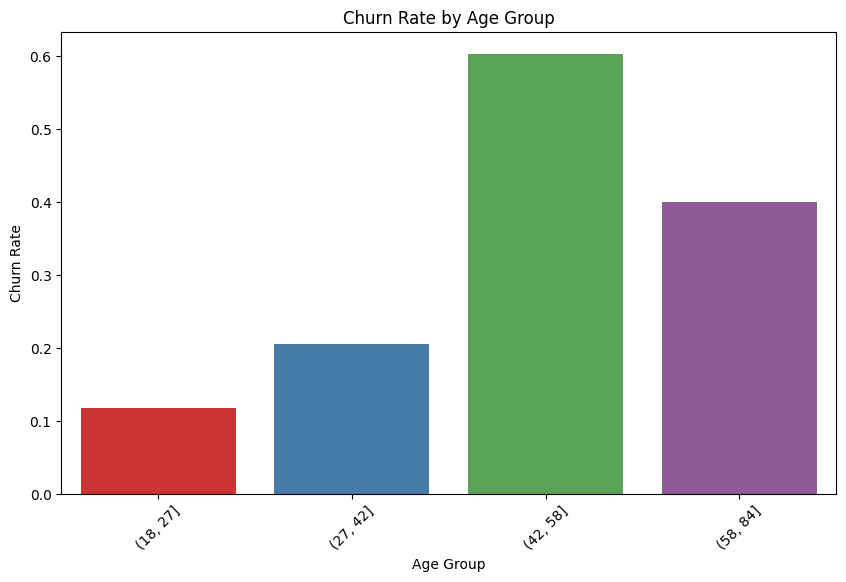

In [49]:
# 베이비붐 세대: 46년생 ~ 64년생

# 현재 (2023년 기준) 나이: 59세 ~ 77세
# X세대: 65년생 ~ 80년생

# 현재 (2023년 기준) 나이: 43세 ~ 58세
# 밀레니얼 세대 (Y세대): 81년생 ~ 95년생

# 현재 (2023년 기준) 나이: 28세 ~ 42세
# Z세대: 96년생 ~ 12년생

# 현재 (2023년 기준) 나이: 11세 ~ 27세

age_bins = [18, 27, 42, 58, 84]
# 각 연령대별 churn rate 계산
df['age_group'] = pd.cut(df['age'], bins=age_bins)
churn_rate_by_age = df.groupby('age_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='churn', data=churn_rate_by_age, palette='Set1')
plt.title('Churn Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

In [50]:
# 각 구간별 데이터 개수와 churn rate 확인
for i in range(len(age_bins)-1):
    lower_bound = age_bins[i]
    upper_bound = age_bins[i+1]
    group_df = df[(df['age'] >= lower_bound) & (df['age'] < upper_bound)]
    churn_rate = group_df['churn'].mean()
    print(f"Age Group {i+1} (range {lower_bound} to {upper_bound}): {group_df.shape[0]} rows, Churn Rate: {churn_rate:.2f}")


Age Group 1 (range 18 to 27): 108 rows, Churn Rate: 0.13
Age Group 2 (range 27 to 42): 832 rows, Churn Rate: 0.19
Age Group 3 (range 42 to 58): 461 rows, Churn Rate: 0.56
Age Group 4 (range 58 to 84): 90 rows, Churn Rate: 0.43


#### age group를 조금 더 세분화

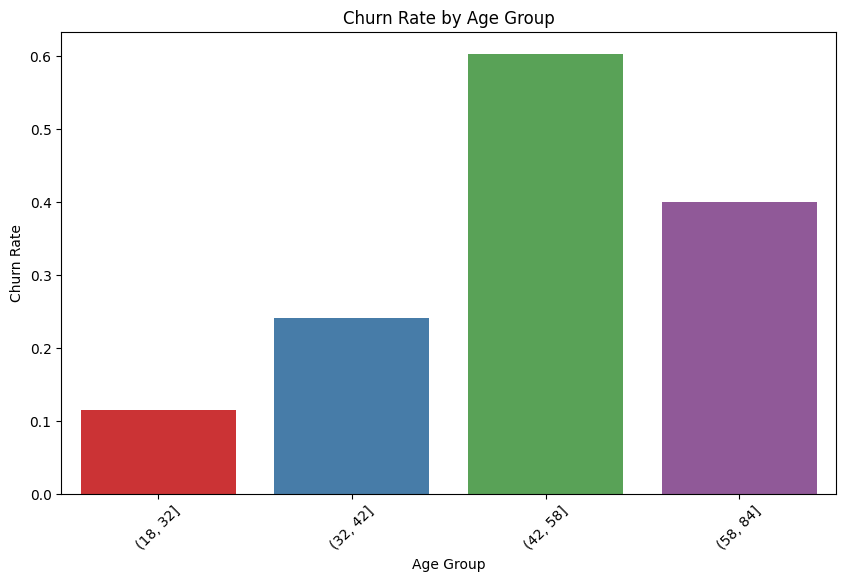

In [69]:
## 18~32 : 독일의 평균 결혼 나이인 32세를 기준 (결혼 전), 주로 모바일 뱅킹 앱을 통해 은행 서비스를 이용. 일반적으로 신용카드 및 대출에 관심이 높고 저축보다는 투자/적금에 관심이 높음
## 33~56 : 독일의 평균 독립 나이인 24세를 기준으로 더해줌 (결혼 후 자녀와 함께), 가정을 위한 금융 서비스에 관심이 높음, 대출/주택 담보 등의 금융상품을 많이 이용, 자산 관리 및 투자에 관심이 증가
## 57~84 결혼 후 자녀가 독립한 상태. 모바일/인터넷 뱅킹 보다는 오프라인을 선호, 안정적인 상품에 주로 투자, 퇴직/연금에 관심이 많음

#세대별 구분법
# age_bins = [18, 27, 42, 58, 84]
# 결혼별 구분법
# age_bins = [18, 32, 56, 84]

# 통합 bins
age_bins = [18, 32, 42, 58, 84]

# 각 연령대별 churn rate 계산
df['age_group'] = pd.cut(df['age'], bins=age_bins)

churn_rate_by_age = df.groupby('age_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='churn', data=churn_rate_by_age, palette='Set1')
plt.title('Churn Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

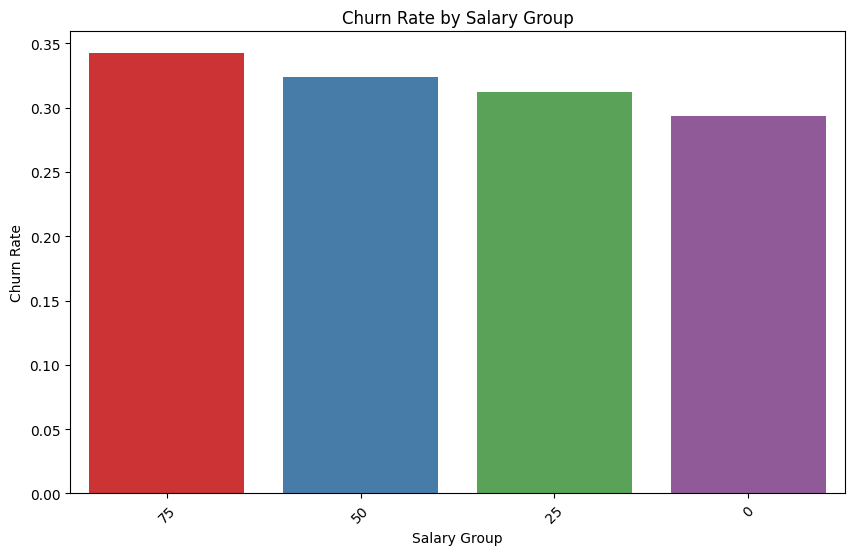

In [51]:
# Quantile statistics
# Minimum	11.58
# 5-th percentile	9981.056
# Q1	51113.14
# median	102184.66
# Q3	151167.94
# 95-th percentile	191464.82
# Maximum	199970.74
# Range	199959.16

# 통계량을 기준으로 salary_bins 설정
salary_bins = [11.58, 51113.14, 102184.66, 151167.94, 199992.48]
labels = ['75', '50', '25', '0']

# 각 salary 구간에 속하는지 확인
df['salary_group'] = pd.cut(df['estimated_salary'], bins=salary_bins, labels=labels)

# 각 salary 구간별 churn rate 계산
churn_rate_by_salary = df.groupby('salary_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='salary_group', y='churn', data=churn_rate_by_salary, palette='Set1')
plt.title('Churn Rate by Salary Group')
plt.xlabel('Salary Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()


In [52]:
for i in range(len(salary_bins)-1):
    lower_bound = salary_bins[i]
    upper_bound = salary_bins[i+1]
    group_df = df[(df['estimated_salary'] >= lower_bound) & (df['estimated_salary'] < upper_bound)]
    churn_rate = group_df['churn'].mean()
    print(f"Age Group {i+1} (range {lower_bound} to {upper_bound}): {group_df.shape[0]} rows, Churn Rate: {churn_rate:.2f}")

Age Group 1 (range 11.58 to 51113.14): 379 rows, Churn Rate: 0.34
Age Group 2 (range 51113.14 to 102184.66): 374 rows, Churn Rate: 0.32
Age Group 3 (range 102184.66 to 151167.94): 372 rows, Churn Rate: 0.31
Age Group 4 (range 151167.94 to 199992.48): 366 rows, Churn Rate: 0.29


#### salary가 높아질수록 Churn rate가 약간씩 낮아지는 모습을 확인 가능

#### 소득분위 5 배율을 기준으로 나눠보기 + credit card 유무도 확인

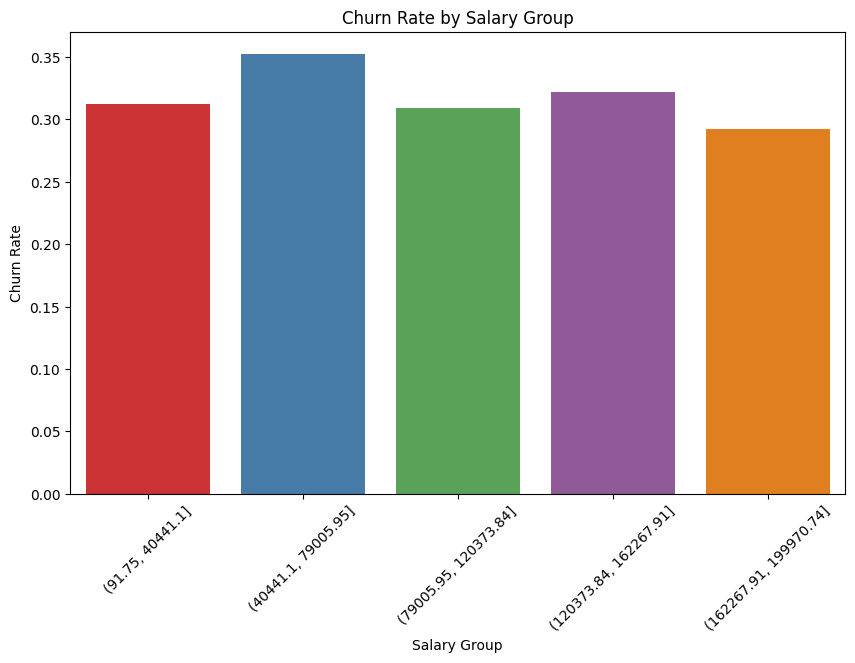

In [53]:
# estimated_salary를 20%씩의 구간으로 나누기
salary_bins = pd.qcut(df['estimated_salary'], q=5, retbins=True)[1].tolist()

# 각 salary 구간에 속하는지 확인
df['salary_group'] = pd.cut(df['estimated_salary'], bins=salary_bins)

# 각 salary 구간별 churn rate 계산
churn_rate_by_salary = df.groupby('salary_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='salary_group', y='churn', data=churn_rate_by_salary, palette='Set1')
plt.title('Churn Rate by Salary Group')
plt.xlabel('Salary Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

In [54]:
for i in range(len(salary_bins)-1):
    lower_bound = salary_bins[i]
    upper_bound = salary_bins[i+1]
    group_df = df[(df['estimated_salary'] >= lower_bound) & (df['estimated_salary'] < upper_bound)]
    churn_rate = group_df['churn'].mean()
    print(f"Age Group {i+1} (range {lower_bound} to {upper_bound}): {group_df.shape[0]} rows, Churn Rate: {churn_rate:.2f}")

Age Group 1 (range 91.75 to 40441.1): 298 rows, Churn Rate: 0.32
Age Group 2 (range 40441.1 to 79005.95): 298 rows, Churn Rate: 0.35
Age Group 3 (range 79005.95 to 120373.84): 298 rows, Churn Rate: 0.31
Age Group 4 (range 120373.84 to 162267.91): 298 rows, Churn Rate: 0.33
Age Group 5 (range 162267.91 to 199970.74): 298 rows, Churn Rate: 0.29


<ipython-input-55-37f70ac71554>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_0['salary_group'] = pd.cut(group_0['estimated_salary'], bins=salary_bins)


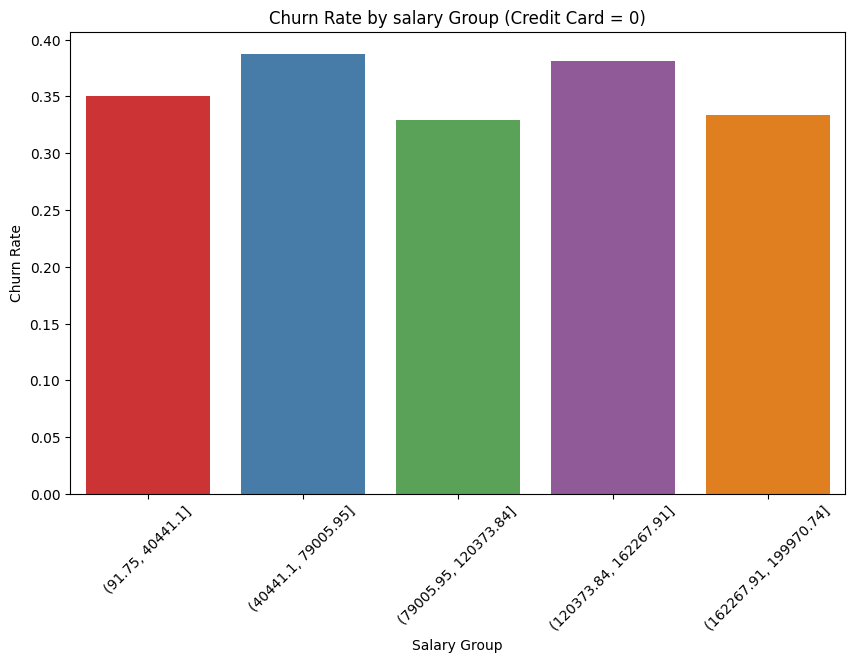

In [55]:
# credit_score를 주어진 기준으로 나누기
group_0 = df[df['credit_card'] == 0]
group_0['salary_group'] = pd.cut(group_0['estimated_salary'], bins=salary_bins)

# 각 그룹의 churn rate 계산
churn_rate_by_salary_group = group_0.groupby('salary_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='salary_group', y='churn', data=churn_rate_by_salary_group, palette='Set1')
plt.title('Churn Rate by salary Group (Credit Card = 0)')
plt.xlabel('Salary Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

#### 4그룹을 제외하고는 차이가 없음

<ipython-input-56-7cdb4889c832>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_0['salary_group'] = pd.cut(group_0['estimated_salary'], bins=salary_bins)


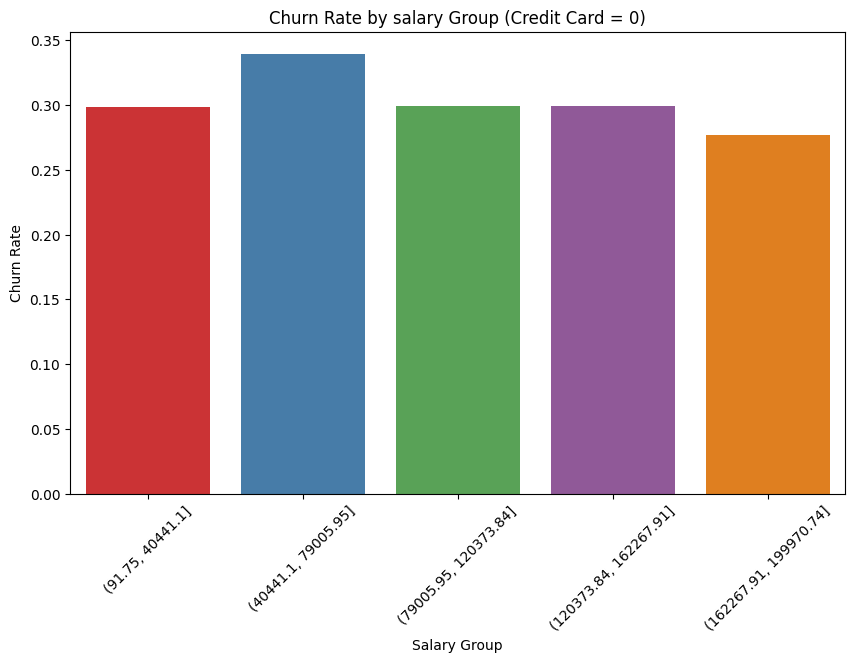

In [56]:
# credit_score를 주어진 기준으로 나누기
group_0 = df[df['credit_card'] == 1]
group_0['salary_group'] = pd.cut(group_0['estimated_salary'], bins=salary_bins)

# 각 그룹의 churn rate 계산
churn_rate_by_salary_group = group_0.groupby('salary_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='salary_group', y='churn', data=churn_rate_by_salary_group, palette='Set1')
plt.title('Churn Rate by salary Group (Credit Card = 0)')
plt.xlabel('Salary Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

#### 통계량을 기준으로 보기

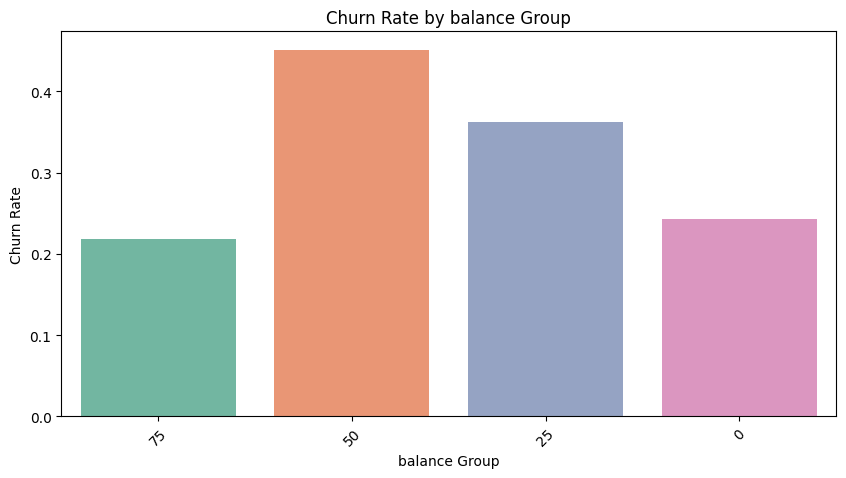

In [57]:
# Minimum	27288.43
# 5-th percentile	74671.898
# Q1	102773.2
# median	119714.25
# Q3	137648.41
# 95-th percentile	164893.72
# Maximum	214346.96
# Range	187058.53
# Interquartile range (IQR)	34875.21

# balance_bins에 따른 데이터 분할
balance_bins = [27288.43, 102773.2, 119714.25, 137648.41, 214346.96]

# 각 credit_score 구간에 속하는지 확인
df['balance_group'] = pd.cut(df['balance'], bins=balance_bins, labels = labels)

# 각 credit_score 구간별 churn rate 계산
churn_rate_by_balance = df.groupby('balance_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x='balance_group', y='churn', data=churn_rate_by_balance, palette='Set2')
plt.title('Churn Rate by balance Group')
plt.xlabel('balance Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()


In [58]:
# 각 구간별 데이터 개수 확인
for i in range(len(balance_bins)-1):
    lower_bound = balance_bins[i]
    upper_bound = balance_bins[i+1]
    group_df = df[(df['balance'] >= lower_bound) & (df['balance'] < upper_bound)]
    print(f"Balance Group {i+1} (range {lower_bound} to {upper_bound}): {group_df.shape[0]} rows")

Balance Group 1 (range 27288.43 to 102773.2): 385 rows
Balance Group 2 (range 102773.2 to 119714.25): 368 rows
Balance Group 3 (range 119714.25 to 137648.41): 376 rows
Balance Group 4 (range 137648.41 to 214346.96): 362 rows


#### 가설 : balance와 credit card를 합치면 chrun rate에 대한 유의미한 차이를 확인 가능할 것이다

<ipython-input-59-7f6052311832>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_0['balance_group'] = pd.cut(group_0['balance'], bins=balance_bins)


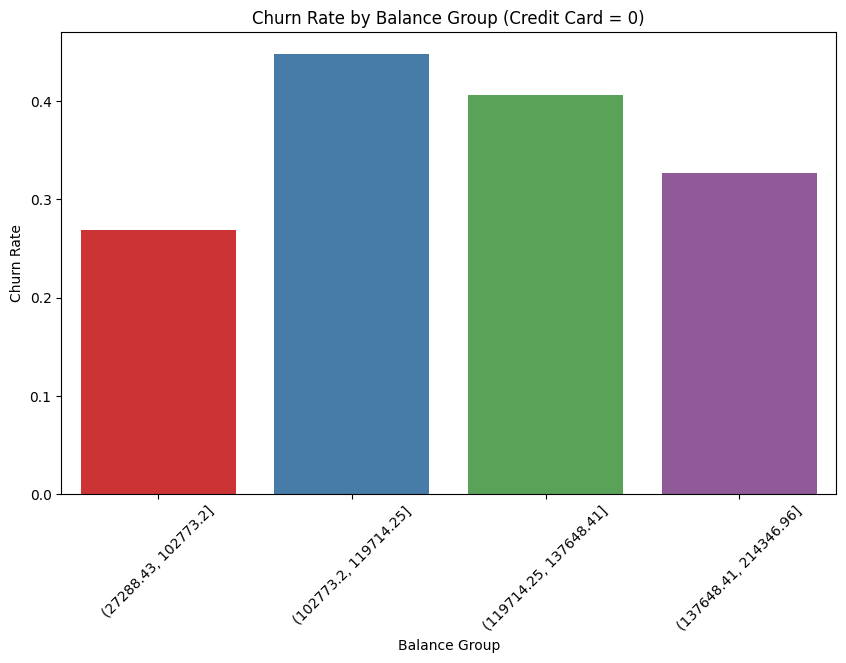

In [59]:
# credit_score를 주어진 기준으로 나누기

group_0 = df[df['credit_card'] == 0]
group_0['balance_group'] = pd.cut(group_0['balance'], bins=balance_bins)

# 각 그룹의 churn rate 계산
churn_rate_by_balance_group = group_0.groupby('balance_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='balance_group', y='churn', data=churn_rate_by_balance_group, palette='Set1')
plt.title('Churn Rate by Balance Group (Credit Card = 0)')
plt.xlabel('Balance Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

In [60]:
# 각 그룹의 데이터 개수와 churn rate 출력
for i, group in enumerate(churn_rate_by_balance_group['balance_group']):
    data_count = group_0[group_0['balance_group'] == group].shape[0]
    churn_rate = churn_rate_by_balance_group.iloc[i]['churn']
    print(f"Balance Group: {group}, Data Count: {data_count}, Churn Rate: {churn_rate}")

Balance Group: (27288.43, 102773.2], Data Count: 119, Churn Rate: 0.2689075630252101
Balance Group: (102773.2, 119714.25], Data Count: 96, Churn Rate: 0.4479166666666667
Balance Group: (119714.25, 137648.41], Data Count: 101, Churn Rate: 0.40594059405940597
Balance Group: (137648.41, 214346.96], Data Count: 101, Churn Rate: 0.32673267326732675


<ipython-input-61-ff690cb4fb6c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_0['balance_group'] = pd.cut(group_0['balance'], bins=balance_bins)


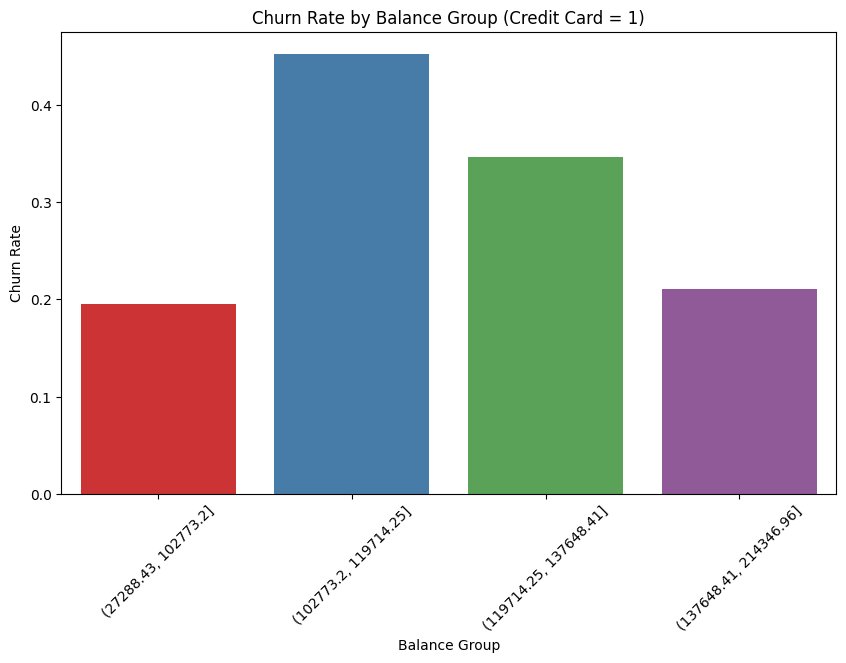

In [61]:
group_0 = df[df['credit_card'] == 1]
group_0['balance_group'] = pd.cut(group_0['balance'], bins=balance_bins)

# 각 그룹의 churn rate 계산
churn_rate_by_balance_group = group_0.groupby('balance_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='balance_group', y='churn', data=churn_rate_by_balance_group, palette='Set1')
plt.title('Churn Rate by Balance Group (Credit Card = 1)')
plt.xlabel('Balance Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

In [62]:
# 각 그룹의 데이터 개수와 churn rate 출력
for i, group in enumerate(churn_rate_by_balance_group['balance_group']):
    data_count = group_0[group_0['balance_group'] == group].shape[0]
    churn_rate = churn_rate_by_balance_group.iloc[i]['churn']
    print(f"Balance Group: {group}, Data Count: {data_count}, Churn Rate: {churn_rate}")

Balance Group: (27288.43, 102773.2], Data Count: 266, Churn Rate: 0.19548872180451127
Balance Group: (102773.2, 119714.25], Data Count: 272, Churn Rate: 0.4522058823529412
Balance Group: (119714.25, 137648.41], Data Count: 274, Churn Rate: 0.3467153284671533
Balance Group: (137648.41, 214346.96], Data Count: 261, Churn Rate: 0.210727969348659


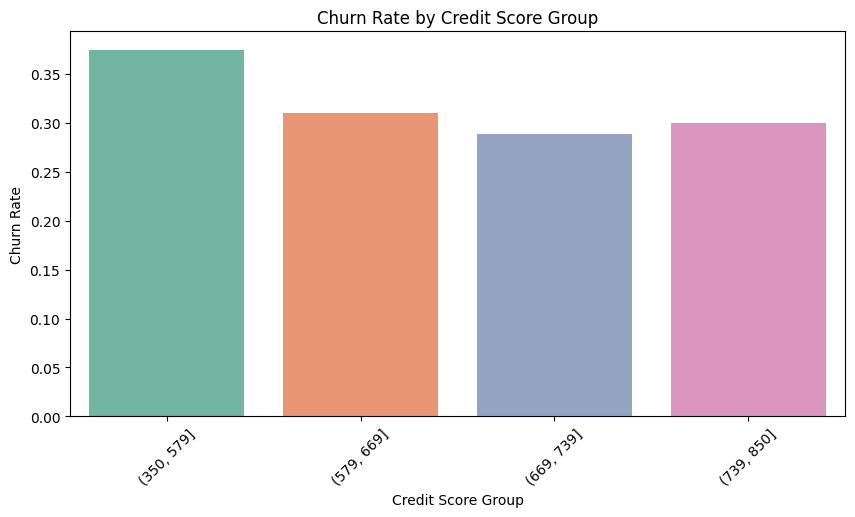

In [63]:
# FICO 표준 평가 방법도 잘 나눠지지 않음
# credit_score_bins = [350, 579, 669, 739, 799, 850]

# FICO 표준 평가 modified
credit_score_bins = [350, 579, 669, 739, 850]

# 각 credit_score 구간에 속하는지 확인
df['credit_score_group'] = pd.cut(df['credit_score'], bins=credit_score_bins)

# 각 credit_score 구간별 churn rate 계산
churn_rate_by_credit_score = df.groupby('credit_score_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x='credit_score_group', y='churn', data=churn_rate_by_credit_score, palette='Set2')
plt.title('Churn Rate by Credit Score Group')
plt.xlabel('Credit Score Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()


In [64]:
# products_number별 churn rate와 데이터 개수 구하기
cs_groups = df.groupby('credit_score_group')['churn']

# 각 그룹의 데이터 개수 구하기
group_counts = cs_groups.count()

# 각 그룹의 churn rate 구하기
group_churn_rate = cs_groups.mean()

# 결과 출력
print("Products_number\tData Count\tChurn Rate")
for products_number, count, churn_rate in zip(group_counts.index, group_counts, group_churn_rate):
    print(f"{products_number}\t\t{count}\t\t{churn_rate:.2f}")

Products_number	Data Count	Churn Rate
(350, 579]		331		0.37
(579, 669]		529		0.31
(669, 739]		340		0.29
(739, 850]		290		0.30


#### 가설 : credit card를 가진 사람들은 credit score가 높을 것이며, 그렇지 않은 그룹과 churn rate에 유의미한 차이가 있을것이다.

<ipython-input-65-aa1baa93be8b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_0['credit_score_group'] = pd.cut(group_0['credit_score'], bins=credit_score_bins)


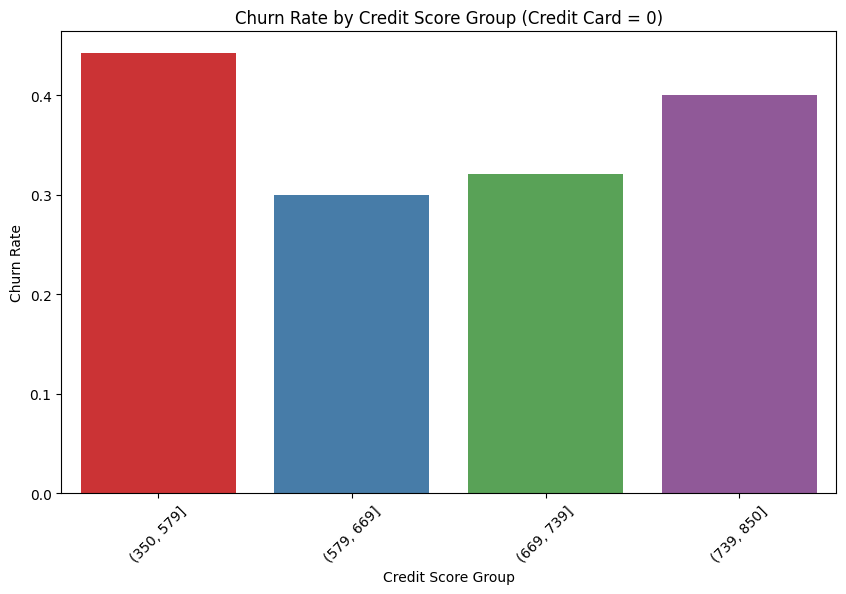

In [65]:
# credit_score를 주어진 기준으로 나누기

group_0 = df[df['credit_card'] == 0]
group_0['credit_score_group'] = pd.cut(group_0['credit_score'], bins=credit_score_bins)

# 각 그룹의 churn rate 계산
churn_rate_by_credit_score_group = group_0.groupby('credit_score_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='credit_score_group', y='churn', data=churn_rate_by_credit_score_group, palette='Set1')
plt.title('Churn Rate by Credit Score Group (Credit Card = 0)')
plt.xlabel('Credit Score Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

In [66]:
# 각 그룹의 데이터 개수와 churn rate 출력
for i, group in enumerate(churn_rate_by_credit_score_group['credit_score_group']):
    data_count = group_0[group_0['credit_score_group'] == group].shape[0]
    churn_rate = churn_rate_by_credit_score_group.iloc[i]['churn']
    print(f"Credit Score Group: {group}, Data Count: {data_count}, Churn Rate: {churn_rate}")


Credit Score Group: (350, 579], Data Count: 86, Churn Rate: 0.4418604651162791
Credit Score Group: (579, 669], Data Count: 137, Churn Rate: 0.29927007299270075
Credit Score Group: (669, 739], Data Count: 103, Churn Rate: 0.32038834951456313
Credit Score Group: (739, 850], Data Count: 90, Churn Rate: 0.4


<ipython-input-67-300b0ce3dce9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_0['credit_score_group'] = pd.cut(group_0['credit_score'], bins=credit_score_bins)


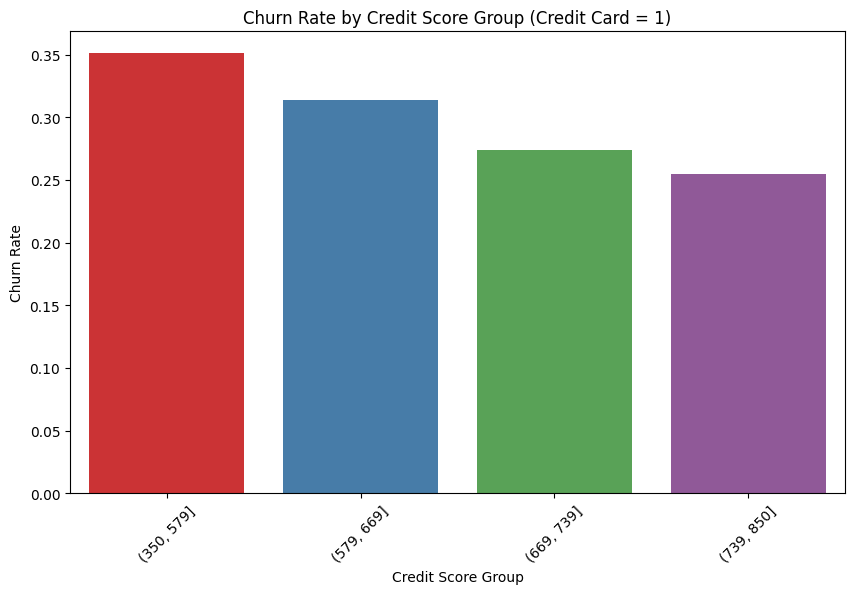

In [67]:
# credit_score를 주어진 기준으로 나누기
group_0 = df[df['credit_card'] == 1]
group_0['credit_score_group'] = pd.cut(group_0['credit_score'], bins=credit_score_bins)

# 각 그룹의 churn rate 계산
churn_rate_by_credit_score_group = group_0.groupby('credit_score_group')['churn'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='credit_score_group', y='churn', data=churn_rate_by_credit_score_group, palette='Set1')
plt.title('Churn Rate by Credit Score Group (Credit Card = 1)')
plt.xlabel('Credit Score Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

In [68]:
# 각 그룹의 데이터 개수와 churn rate 출력
for i, group in enumerate(churn_rate_by_credit_score_group['credit_score_group']):
    data_count = group_0[group_0['credit_score_group'] == group].shape[0]
    churn_rate = churn_rate_by_credit_score_group.iloc[i]['churn']
    print(f"Credit Score Group: {group}, Data Count: {data_count}, Churn Rate: {churn_rate}")


Credit Score Group: (350, 579], Data Count: 245, Churn Rate: 0.3510204081632653
Credit Score Group: (579, 669], Data Count: 392, Churn Rate: 0.3137755102040816
Credit Score Group: (669, 739], Data Count: 237, Churn Rate: 0.2742616033755274
Credit Score Group: (739, 850], Data Count: 200, Churn Rate: 0.255
